# Import lib


In [1]:
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,BatchNormalization,MaxPooling2D,Dropout, Add
from tensorflow.keras.models import Model

# useful for getting number of output classes
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

# Dataset

In [2]:
train_path = 'archive/new_dataset/train'
test_path = 'archive/new_dataset/test'

In [3]:
classes = glob('archive/colored_images_mod/train/*')

In [4]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 2929 images belonging to 5 classes.


In [6]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224, 224),
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 733 images belonging to 5 classes.


# Model 

In [17]:
# Define the model parameters using functional api

inputs = Input(shape=(224,224,3))
cnn1 = Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu')(inputs)
bnor1 = BatchNormalization()(cnn1)
max1 = MaxPooling2D(pool_size=(2,2))(bnor1)

cnn2 = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(max1)
bnor2 = BatchNormalization()(cnn2)
max2 = MaxPooling2D(pool_size=(3,3))(bnor2)


cnn3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(max2)
bnor3 = BatchNormalization()(cnn3)

cnn4 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
bnor4 = BatchNormalization()(cnn4)

cnn5 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
add = Add()([cnn5,cnn3])
bnor4 = BatchNormalization()(add)

cnn6 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
add2 = Add()([cnn6,cnn3,cnn4])
bnor4 = BatchNormalization()(add2)

cnn7 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor4)
add3 = Add()([cnn7,cnn3,cnn4,cnn5])
bnor5 = BatchNormalization()(add3)
max3 = MaxPooling2D(pool_size=(2,2))(bnor5)

flat = Flatten()(max3)
dense1  = Dense(1024, activation = 'relu')(flat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1024, activation = 'relu')(drop1)
add4 = Add()([dense2,dense1])
dense3 = Dense(1024, activation = 'relu')(add4)
drop2 = Dropout(0.5)(dense3)
outputs = Dense(5, activation = 'softmax')(drop2)

In [18]:
model = Model(inputs=inputs, outputs=outputs, name='UGP_model') # defining the model

In [19]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

model.summary()

Model: "UGP_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 54, 54, 128)  46592       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 54, 54, 128)  512         conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 27, 27, 128)  0           batch_normalization_14[0][0]     
__________________________________________________________________________________________

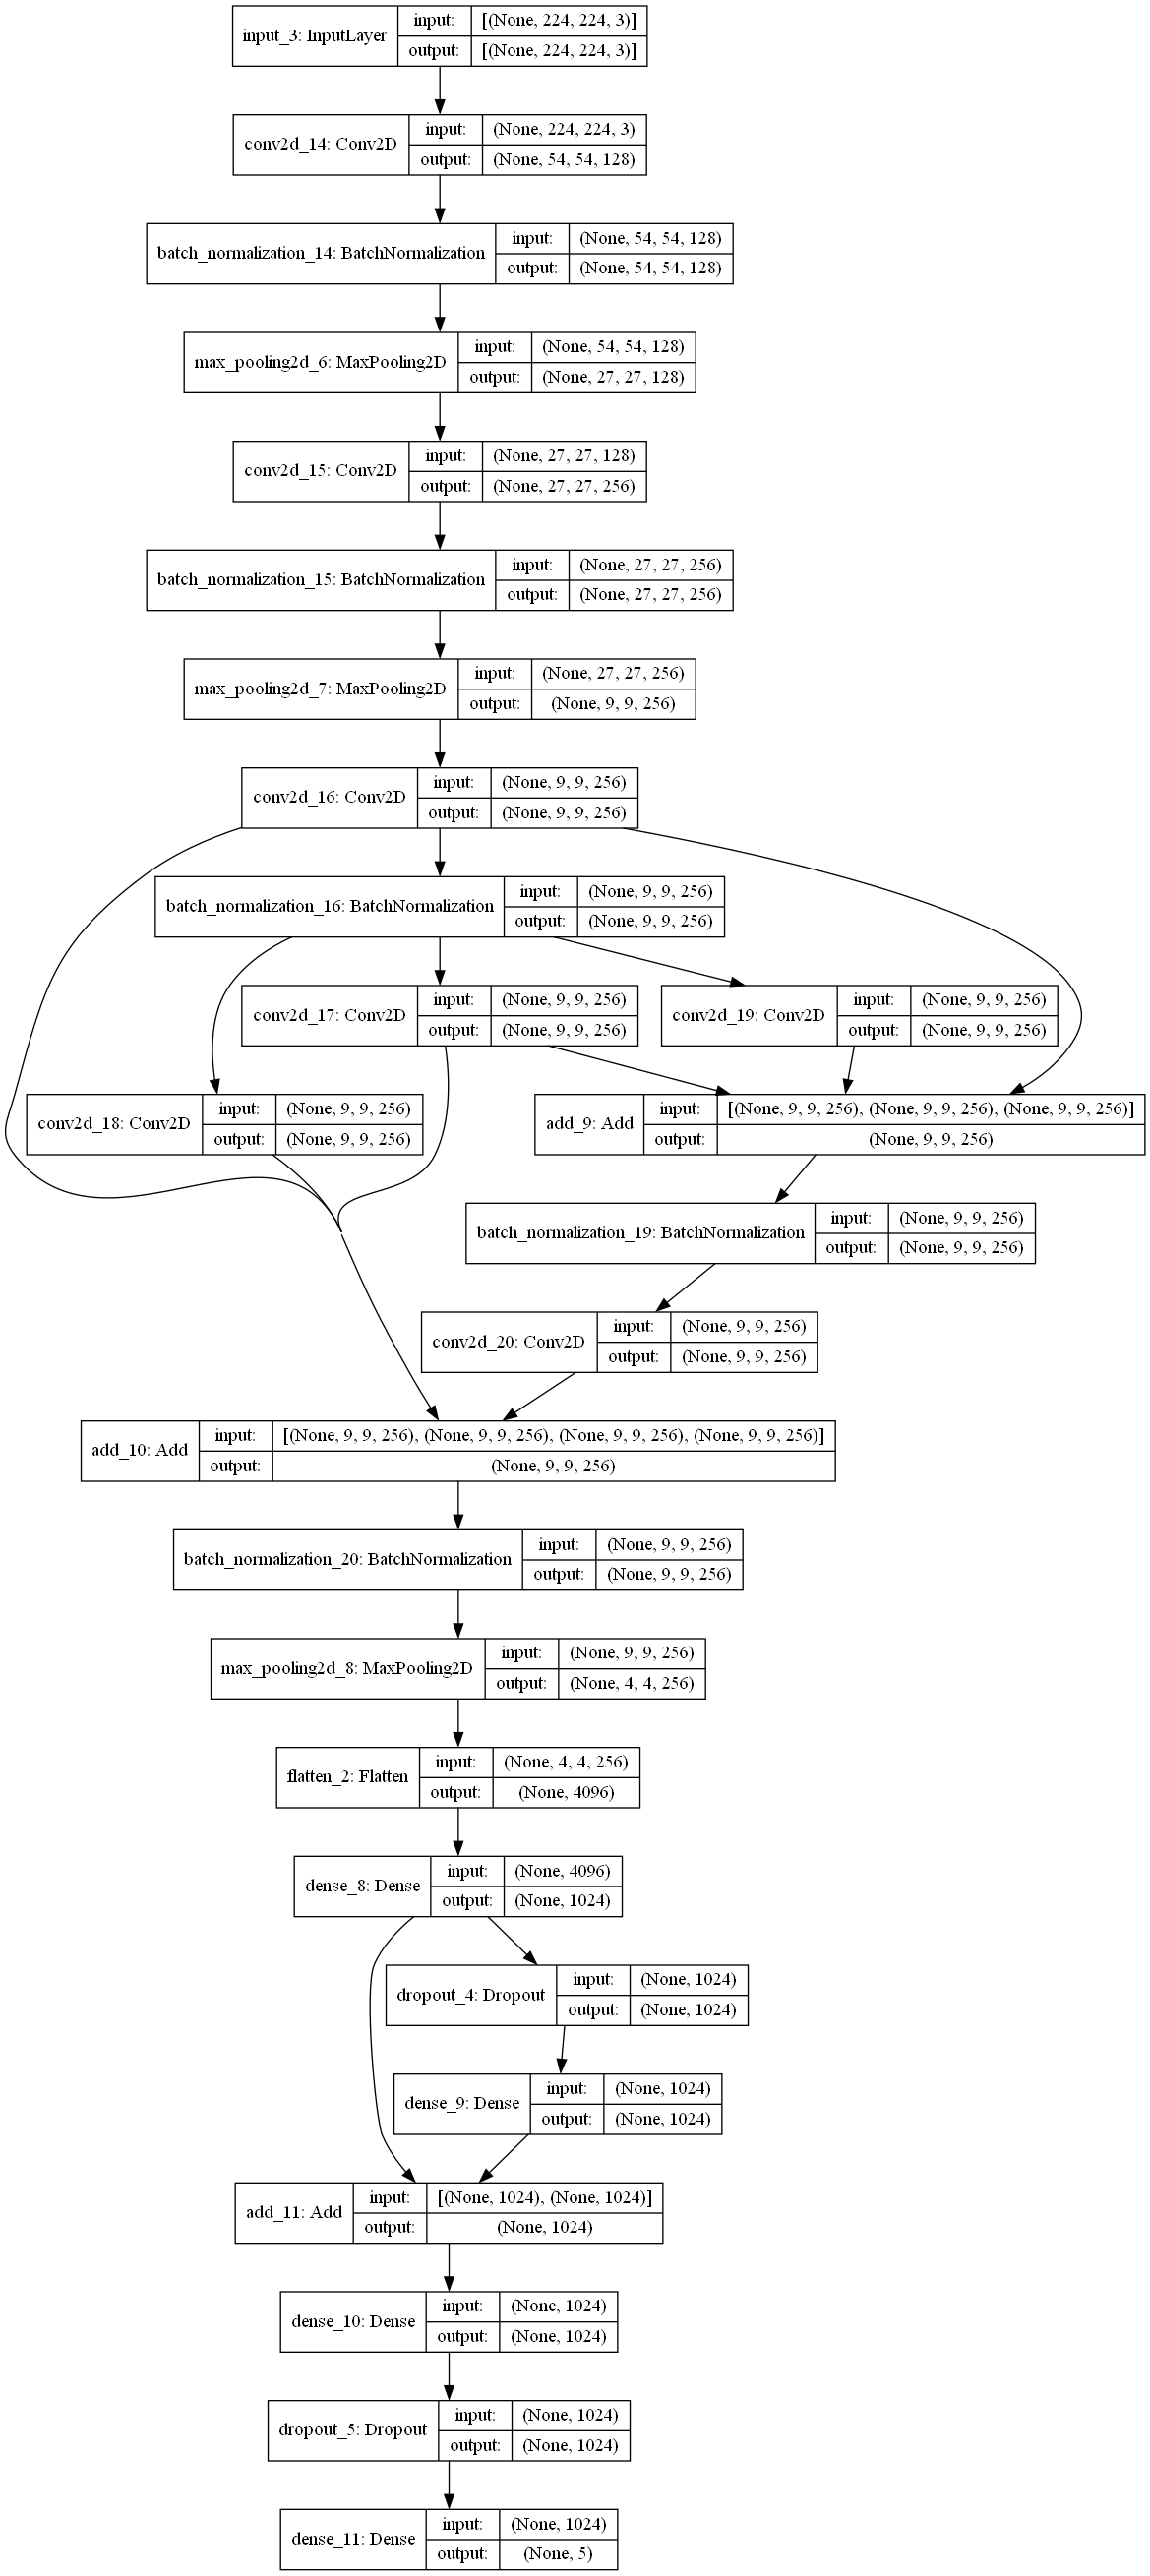

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 100,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/100
46/46 [==============================] - 28s 587ms/step - loss: 1.8892 - accuracy: 0.5534 - val_loss: 1.8786 - val_accuracy: 0.4939
Epoch 2/100
46/46 [==============================] - 27s 586ms/step - loss: 0.9958 - accuracy: 0.6354 - val_loss: 1.4673 - val_accuracy: 0.3793
Epoch 3/100
46/46 [==============================] - 28s 598ms/step - loss: 0.9049 - accuracy: 0.6801 - val_loss: 1.8180 - val_accuracy: 0.3274
Epoch 4/100
46/46 [==============================] - 28s 615ms/step - loss: 0.8501 - accuracy: 0.6944 - val_loss: 1.8011 - val_accuracy: 0.3315
Epoch 5/100
46/46 [==============================] - 35s 758ms/step - loss: 0.8401 - accuracy: 0.6965 - val_loss: 1.3968 - val_accuracy: 0.4529
Epoch 6/100
46/46 [==============================] - 33s 714ms/step - loss: 0.8363 - accuracy: 0.6941 - val_loss: 1.3987 - val_accuracy: 0.4802
Epoch 7/100
46/46 [==============================] - 34s 729ms/step - loss: 0.8396 - accuracy: 0.6982 - val_loss: 1.5684 - val_accuracy:

46/46 [==============================] - 31s 675ms/step - loss: 0.4996 - accuracy: 0.8129 - val_loss: 0.8369 - val_accuracy: 0.7326
Epoch 58/100
46/46 [==============================] - 31s 670ms/step - loss: 0.4852 - accuracy: 0.8105 - val_loss: 0.7082 - val_accuracy: 0.7381
Epoch 59/100
46/46 [==============================] - 31s 666ms/step - loss: 0.4897 - accuracy: 0.8139 - val_loss: 0.7972 - val_accuracy: 0.7476
Epoch 60/100
46/46 [==============================] - 31s 666ms/step - loss: 0.4940 - accuracy: 0.8122 - val_loss: 0.9841 - val_accuracy: 0.6889
Epoch 61/100
46/46 [==============================] - 34s 728ms/step - loss: 0.4772 - accuracy: 0.8214 - val_loss: 0.7198 - val_accuracy: 0.7408
Epoch 62/100
46/46 [==============================] - 32s 692ms/step - loss: 0.4806 - accuracy: 0.8170 - val_loss: 0.7496 - val_accuracy: 0.7258
Epoch 63/100
46/46 [==============================] - 34s 738ms/step - loss: 0.4497 - accuracy: 0.8293 - val_loss: 0.7509 - val_accuracy: 0.751

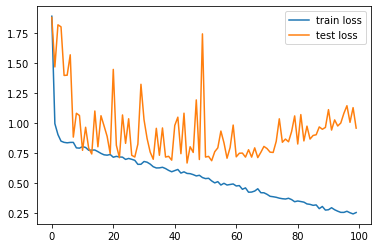

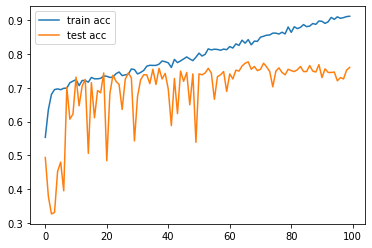

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()